<a href="https://colab.research.google.com/github/annarim/arimlee/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4%EC%99%80_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

훈련 데이터 준비

(60000, 28, 28) (10000, 28, 28)


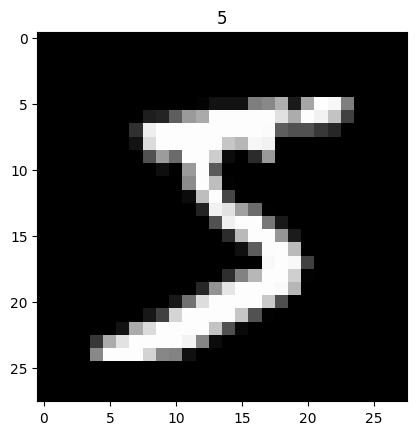

훈련용 데이터의 형태: (60000, 784) 테스트용 데이터 형태: (10000, 784)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

#MNIST 읽어들이기
(x_train, t_train),(x_test, t_test) = mnist.load_data()
print(x_train.shape, x_test.shape) #훈련데이터,테스트 데이터 모양 출력, 28x28의 손으로 쓴 문자 이미지가 6만 장

#각 픽셀의 값을 0~1의 범위에 넣는다
x_train = x_train/255
x_test = x_test/255

#손으로 쓴 문자 이미지를 1개 표시
plt.imshow(x_train[0].reshape(28,28), cmap="gray")
plt.title(t_train[0])
plt.show()

#1차원으로 변환
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)
print("훈련용 데이터의 형태:", x_train.shape, "테스트용 데이터 형태:", x_test.shape)

In [13]:
#VAE 각 설정
epochs = 10
batch_size = 128
n_in_out = 784   #입출력층의 뉴런 수
n_z = 2   #잠재 변수의 수(차원 수)
n_mid = 256   #중간층의 뉴런 수

#모델 구축
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import metrics   #평가 함수

from tensorflow.python.keras.layers import Input, Dense, Lambda
from tensorflow.python.keras import backend as K   #난수의 발생에 사용

#잠재 변수를 샘플링하기 위한 함수
def z_sample(args):
  mu, log_var = args   #잠재 변수의 평균값과 분산의 대수
  epsilon = K.random_normal(shape=K.shape(log_var), mean=0, stddev=1)
  return mu + epsilon * K.exp(log_var/2)   #Reparametrization Trick에 의해 잠재 변수를 구한다

#Encoder
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)
mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu, log_var])

#Decoder
mid_decoder = Dense(n_mid, activation="relu")  #뒤에서 사용
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid")  #뒤에서 사용
y = out_decoder(h_decoder)

#VAE의 모델을 생성
model_vae = Model(x,y)

#손실 함수
eps = 1e-7  #log 안이 0이 되는 것을 막는다
rec_loss = K.sum(-x*K.log(y+eps)-(1-x)*K.log(1-y+eps))/batch_size  #재구성 오차

reg_loss = -0.5*K.sum(1+log_var-K.square(mu)-K.exp(log_var))/batch_size #정칙화 항
vae_loss = rec_loss+reg_loss

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 256)          200960      input_8[0][0]                    
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 2)            514         dense_22[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 2)            514         dense_22[0][0]                   
____________________________________________________________________________________________

학습

In [14]:
model_vae.fit(x_train,x_train,shuffle=True,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 8s 14ms/step - loss: 204.8775 - val_loss: 175.0650
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 171.9634 - val_loss: 166.9008
Epoch 3/10
469/469 [==============================] - 8s 17ms/step - loss: 167.2674 - val_loss: 164.4761
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 165.1238 - val_loss: 162.8349
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 163.6078 - val_loss: 161.4987
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 162.3029 - val_loss: 160.1396
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 161.1196 - val_loss: 159.4066
Epoch 8/10
469/469 [==============================] - 8s 17ms/step - loss: 159.9711 - val_loss: 158.1864
Epoch 9/10
469/469 [==============================] - 5s 11ms/step - loss: 158.8893 - val_loss: 157.3325
Epoch 10/10
469/469 [==============================] - 

잠재 공간 가시화

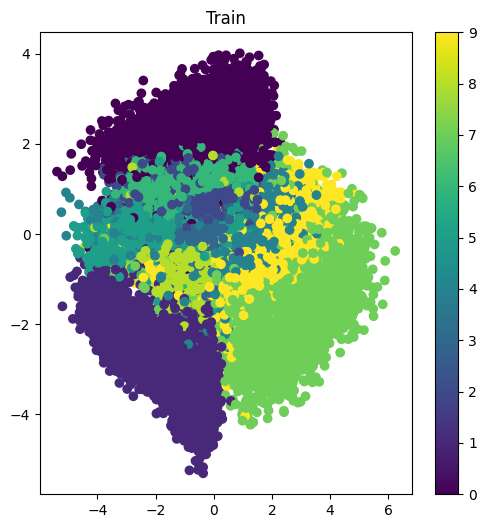

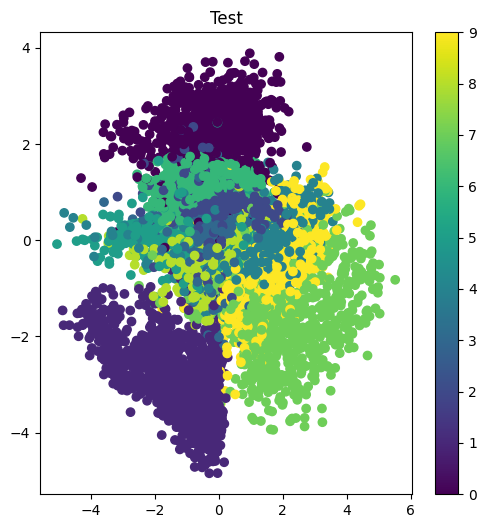

In [17]:
#잠재 변수를 얻기 위한 모델
encoder = Model(x,z)

#훈련 데이터로부터 만든 잠재 변수를 2차원 플롯
z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(z_train[:,0], z_train[:,1], c=t_train)  #라벨을 색으로 나타낸다
plt.title("Train")
plt.colorbar()
plt.show()

#테스트 데이터를 입력해서 잠재 공간에 2차원 플롯한다 > 정답 라벨을 색으로 표시
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(z_test[:,0], z_test[:,1], c=t_test)
plt.title("Test")
plt.colorbar()
plt.show()

이미지 생성

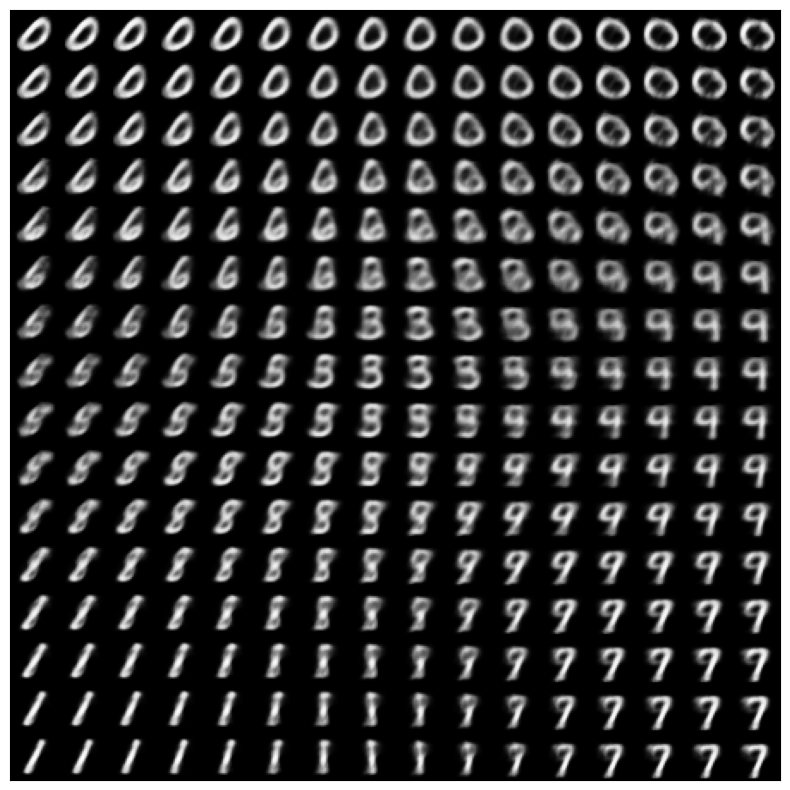

In [21]:
#이미지 생성기
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder(input_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

#이미지를 나열하는 설정
n = 16   #손으로 쓴 문자 이미지를 16x16 나열한다
image_size = 28
matrix_image = np.zeros((image_size*n, image_size*n))  #전체 이미지

#잠재 변수
z_1 = np.linspace(2, -2, n)  #각 행 
z_2 = np.linspace(-2, 2, n)  #각 열

#잠재 변수를 변화시켜서 이미지 생성
for i, z1 in enumerate(z_1):
  for j, z2 in enumerate(z_2):
    decoded = generator.predict(np.array([[z2,z1]]))  #x축, y축의 순서로 넣는다
    image = decoded[0].reshape(image_size, image_size)
    matrix_image[i*image_size : (i+1)*image_size, j*image_size: (j+1)*image_size] = image

plt.figure(figsize=(10,10))
plt.imshow(matrix_image, cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  #축 눈금의 라벨과 선을 지운다 
plt.show()